In [132]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate, PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from typing import List, Dict, Any
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import PydanticOutputParser
import os
from dotenv import load_dotenv
# from langchain.document_loaders import PyMuPDFLoader
from typing import List, Dict, Any, Optional
import fitz
from pydantic import BaseModel, Field
load_dotenv()

True

In [133]:
os.environ["LANGSMITH_PROJECT"] = f"MineD 2025"

In [134]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [135]:
# from langchain_huggingface import HuggingFaceEndpoint

# llm = HuggingFaceEndpoint(
#     # repo_id="mistralai/Mixtral-8x7B-Instruct-v0.1",
#     repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
#     task="text-generation", 
#     do_sample=False,
# )


In [136]:
# llm = ChatGroq(model="gemma2-9b-it")

In [137]:
#base model to hold the metadata, and slide summeries that the llm will extract
class ResPaperText(BaseModel):
    # authors: str = Field(..., description="List of authors of the research paper")
    # title: str = Field(..., description="Title of the research paper")
    # submission_date: str = Field(..., description="Submission date of the research paper")
    # keywords: List[str] = Field(..., description="List of keywords associated with the research paper")
    # references: List[str] = Field(..., description="List of references cited in the research paper")
    # abstract: str = Field(..., description="Abstract of the research paper")
    conclusion: str = Field(..., description="Conclusion of the research paper")

In [138]:
# Define Pydantic Model for PPT slides
class SlideContent(BaseModel):
    title: str = Field(..., description="Title of the particular slide")
    bullet_points: Optional[List[str]] = Field(None, description="Content in bullet points form for the slide")
    notes: Optional[str] = Field(None, description="Additional notes for the slide")
    images: Optional[List[str]] = Field(None, description="List of relevant image paths for the slide")

class PPTPresentation(BaseModel):
    title: str = Field(..., description="Title of the presentation")
    authors: List[str] = Field(..., description="List of authors of the presentation")
    institution: str = Field(..., description="Institution associated with the presentation")
    slides: List[SlideContent] = Field(..., description="List of slides, in the presentation,which are SlideContent schemas.")

class Dialogue(BaseModel):
    text: str = Field(..., description="The text of dialogue")

class Conversation(BaseModel):
    katherine: List[Dialogue] = Field(..., description="Katherine's dialogues")
    clay: List[Dialogue] = Field(..., description="Clay's dialogues")
    order: List[str] = Field(..., description="The order of dialogues denoted by the names of the speaker")


In [139]:
class ResPaperExtractState(TypedDict):
    pdf_path: Optional[str] = None  # Path to the PDF file
    extracted_text: Optional[str] = None  # Full extracted text from the PDF
    extracted_images: Optional[Dict[str,str]] = None  # Paths to extracted images
    slides_content: Optional[List[Dict[str, str]]] = None  # Prepared content for PowerPoint slides
    ppt_object: PPTPresentation
    summary_text: str
    convo: Conversation

In [140]:
def load_pdf(state: ResPaperExtractState):
    pdf_path = state["pdf_path"]
    doc = fitz.open(pdf_path)  # Load the PDF only once
    
    extracted_text = []
    extracted_images = dict()
    output_folder = "extracted_images"
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through each page
    img_cntr=1
    for page_number, page in enumerate(doc):
        # Extract text
        text = page.get_text("text")
        extracted_text.append(text)

        # Extract images
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            img_filename = f"{output_folder}/page_{page_number+1}_img_{img_index+1}.{image_ext}"
            
            with open(img_filename, "wb") as img_file:
                img_file.write(image_bytes)
            
            extracted_images[f"Fig{img_cntr}"] = img_filename
            img_cntr+=1

    # Combine text from all pages
    full_text = "\n".join(extracted_text)

    # Update state
    return {"extracted_text": full_text, "extracted_images": extracted_images}

In [141]:
system_message = SystemMessagePromptTemplate.from_template(
    """You are an expert in creating PowerPoint presentations. Generate a structured PowerPoint (PPT) presentation 
    that summarizes a research paper based on the provided extracted text. Follow these instructions:
    
    Remember that the objective of this PPT is for a third party to understand the key points of the research paper, and 
    give them a gist of the research paper.

    - Title Slide: Include the research paper title, authors, and institution.
    - Introduction Slide: Summarize the problem, objectives, and motivation.
    - Methods Slide: Briefly explain the methodology, datasets, and experimental setup.
    - Results Slide: Summarize key findings with bullet points. Mention any visuals (graphs, tables) found from the extracted text. You should definetly mention in the presentation any figures related to a performance metric or tables that are mentioned in the extracted text.
    - Graphics: Include any images of graphs or charts or other images, relevant to the results,or images depicting a performance metric,
      that are mentioned in the extracted text. You can find such images by looking for any captions that mention figures or tables. 
      It is necessary to name this slide as Graphics.
      Note that you should only mention the image number, like Fig1, Fig2, etc...
      Include only relevant image names.
    - Discussion Slide: Explain the significance of results and compare with prior work.
    - Conclusion Slide: Summarize key takeaways and potential future work.
    - References Slide: Include citations if available.

    Additional Guidelines:
    - Keep slides concise (use bullet points).
    - Maintain a professional and visually appealing slide design.
    - Give the text in markdown format.
    - Each slide should have rich information content, summarizing the information related to the particular slide heading, 
    and also include some content that is related to the slide heading but not directly mentioned in the extracted text.
    - Also keep in mind that the text for each slide should not be too lengthy, and should be concise and to the point.

    {format_instructions}
    """
)

# Human Message: Supplies extracted text from the research paper
human_message = HumanMessagePromptTemplate.from_template("Here is the extracted text:\n\n{extracted_text}")

parser = JsonOutputParser(pydantic_object=PPTPresentation)
# Combine into a structured chat prompt
chat_prompt = ChatPromptTemplate(
    messages=[system_message, human_message],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

def get_data(state):
    extracted_text = state["extracted_text"]
    
    # Format prompt with extracted text
    
    # Invoke LLM with structured output
    chain = chat_prompt | llm | parser

    # Parse structured output into Pydantic model
    ppt_object = chain.invoke({"extracted_text":extracted_text})
    
    return {"ppt_object": ppt_object}

In [142]:
def generate_summary(state: ResPaperExtractState):
    extracted_text = state["extracted_text"]
    
    summary_template_string = """
You are an expert science communicator who specializes in breaking down complex research papers into engaging, conversational summaries. Your goal is to generate a summary that serves the purposes: 

**Conversational Podcast** – The summary should be structured in a way that makes it engaging for a podcast discussion. 
Imagine two hosts discussing the paper in an insightful yet accessible way. 
Include thought-provoking questions and key discussion points that make the findings compelling to a general audience.

### **Instructions:**
- Start with an **intriguing hook** that captures the essence of the paper in an engaging way. Example: *"What if we could predict network congestion before it even happens? A recent study explores exactly that in the context of V2X communication."*
- Clearly state the **research problem** and why it matters.
- Summarize the **key findings** and their implications, but in a way that sparks curiosity.
- **Use an engaging tone** that makes it feel like a conversation rather than a dry summary.
- Include at least **three discussion-worthy questions** that podcast hosts could debate.
- Highlight any **visual elements** that could be useful for a graphical abstract, such as relationships between variables, experimental results, or unexpected insights.

### **Important Guidelines:**
- Keep it insightful yet engaging—avoid overly technical jargon unless necessary.  
- Don’t make the summary too short; ensure all important elements of the research are covered.  
- Aim for a summary length of **300-500 words** to balance depth with readability.  
- If applicable, include **real-world analogies** or examples to make the findings more relatable. 
- Remember, the goal is to make the research accessible and interesting to a broad audience.
- Return a single string with the summary text, acheiving the above objectives. 

Now, using these guidelines, generate a well-structured summary of the following research paper: {text}  

"""

    summary_template_string_2 = """
You are an expert science communicator who specializes in breaking down complex research papers into engaging, conversational summaries. Your goal is to generate a summary that will be used to generate text for conversational podcast.
The summary should be structured in a way that makes it engaging for a podcast discussion. 
Include thought-provoking questions and key discussion points that make the findings compelling to a general audience.

### **Instructions:**
- Start with an **intriguing hook** that captures the essence of the paper in an engaging way. 
- Clearly state the **research problem** and why it matters.
- Summarize the **key findings** and their implications, but in a way that sparks curiosity.
- **Use an engaging tone** that makes it feel like a conversation rather than a dry summary.
- Include at least **three discussion-worthy questions** that podcast hosts could debate.
- Highlight any **visual elements** that could be useful for a graphical abstract, such as relationships between variables, experimental results, or unexpected insights.

### **Important Guidelines:**
- Keep it insightful yet engaging—avoid overly technical jargon unless necessary.  
- Don’t make the summary too short; ensure all important elements of the research are covered.  
- Aim for a summary length of **300-500 words** to balance depth with readability.  
- If applicable, include **real-world analogies** or examples to make the findings more relatable. 
- Remember, the goal is to make the research accessible and interesting to a broad audience.
- Return a single string with the summary text, acheiving the above objectives. 
Now, using these guidelines, generate a well-structured summary of the following research paper: {text}  

"""
    summary_prompt = PromptTemplate.from_template(summary_template_string_2)
    # Generate summary with LLM
    summary_text = llm.invoke(summary_prompt.format(text=extracted_text))  # No chunking, single LLM call
    
    return {"summary_text": summary_text}

In [143]:
system_message_podcast = SystemMessagePromptTemplate.from_template(
    """You are an expert in creating/writing scripts for podcasts. 
    Consider the given scenario: Two people one girl and one boy who are in final year of their B.Tech, are discussing the given research paper to create an podcast of this research paper
    
    Boy's Name: Clay
    Girl's Name: Katherine
    
    The Girl has complete knowledge about this paper, while the boy doesn't know anything about the paper.
    
    Write a script for a podcast, wherein firstly the girl introduces the paper, but the boy seems clueless.So the boy ask the girl many questions about the paper, to understand the paper and learn more about the keyowrds and topics involved.
    
    The boy's question should cover all the possible doubt that one can have regarding the paper, and the girl should answer that questions correctly.

    General Guideline:
    - Intro must include the name, application and the authors (and their institution)
    - Consider the audience to be technically sound, so you can ue jargons
    - The boys questions should cover all the aspects from methodology, results, literature review, etc
    - Dont make it too obvious that they are discussing about the paper
    - Make the order such that the question asked by clay in previous dialogue is answered by katherine in this dialogue.

    Additional Guidelines:
    - Output in JSON format, this JSON should have two keys, names of boys and girls, in lower case.
    - Each key corresponds to a list, their dialogues in sequential manner
    - Consider that the girl always starts first
    - Also give the order of dialogues, that are to be taken in a sequence
    - Make sure that the number of dialogues in the order and in the lists add up.
    - Both of them dont have to speak alternatively, they can heave continuous dialogues
    - Each and every question asked by clay has to be answered by katherine

    {format_instructions}
    """
)

# Human Message: Supplies extracted text from the research paper
human_message_podcast = HumanMessagePromptTemplate.from_template("Here is the summary of research paper:\n\n{summary_text}. \nMake sure the tone is {tone}")

parser_podcast = JsonOutputParser(pydantic_object=Conversation)
# Combine into a structured chat prompt
chat_prompt_podcast = ChatPromptTemplate(
    messages=[system_message_podcast, human_message_podcast],
    partial_variables={"format_instructions": parser_podcast.get_format_instructions()}
)

def generate_conversation(state: ResPaperExtractState):
    summary_text = state["summary_text"]
    prompt = chat_prompt_podcast.invoke({"summary_text": summary_text, "tone": "informative"})
    llm_out = llm.invoke(prompt)
    parsed = parser_podcast.invoke(llm_out)
    
    return {"convo":parsed}



In [144]:
# builder = StateGraph(ResPaperExtractState)

# builder.add_node("pdf-2-text", load_pdf)
# builder.add_node("text-condensation", get_data)

# builder.add_edge(START, "pdf-2-text")
# builder.add_edge("pdf-2-text", "text-condensation")
# builder.add_edge("text-condensation", END)

# graph = builder.compile()

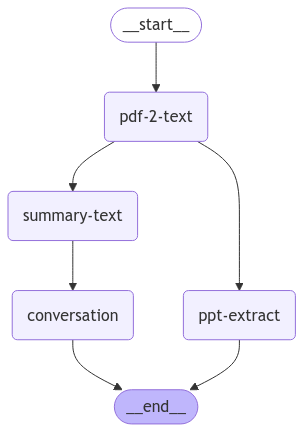

In [145]:

builder = StateGraph(ResPaperExtractState)

builder.add_node("pdf-2-text", load_pdf)
builder.add_node("ppt-extract", get_data)
builder.add_node("summary-text", generate_summary)
builder.add_node("conversation", generate_conversation)

builder.add_edge(START, "pdf-2-text")
builder.add_edge("pdf-2-text", "ppt-extract")
builder.add_edge("pdf-2-text", "summary-text")
builder.add_edge("summary-text", "conversation")
builder.add_edge("ppt-extract", END)
builder.add_edge("conversation", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [146]:
path1 = r"C:\Users\milap\OneDrive\Desktop\CLG\3rd YR\SEM VI\mined_2025\lib\server\Milap_Tathya_ICC_June_2025.pdf"
path2 = r"C:\Users\milap\OneDrive\Desktop\CLG\3rd YR\SEM VI\mined_2025\lib\server\STORM.pdf"
path3 = r"C:\Users\milap\OneDrive\Desktop\CLG\3rd YR\SEM VI\mined_2025\lib\server\SuFIA.pdf"
path4 = r"C:\Users\milap\OneDrive\Desktop\CLG\3rd YR\SEM VI\mined_2025\lib\server\ankit review.pdf"
state_output = graph.invoke({"pdf_path":path3})

In [147]:
state_output["extracted_text"]

'SUFIA: Language-Guided Augmented Dexterity\nfor Robotic Surgical Assistants\nMasoud Moghani1, Lars Doorenbos2, William Chung-Ho Panitch3,\nSean Huver4, Mahdi Azizian4, Ken Goldberg3, Animesh Garg1,4,5\nAbstract— In this work, we present SUFIA, the first frame-\nwork for natural language-guided augmented dexterity for\nrobotic surgical assistants. SUFIA incorporates the strong\nreasoning capabilities of large language models (LLMs) with\nperception modules to implement high-level planning and low-\nlevel control of a robot for surgical sub-task execution. This\nenables a learning-free approach to surgical augmented dexterity\nwithout any in-context examples or motion primitives. SUFIA\nuses a human-in-the-loop paradigm by restoring control to\nthe surgeon in the case of insufficient information, mitigating\nunexpected errors for mission-critical tasks. We evaluate SUFIA\non four surgical sub-tasks in a simulation environment and two\nsub-tasks on a physical surgical robotic platform in

In [148]:
state_output["summary_text"].content

'Imagine a future where surgeons can guide robotic surgical assistants with simple voice commands, like "Lift the needle," and the robot flawlessly executes the task.  That future is closer than you think, thanks to a groundbreaking new framework called SUFIA.\n\nThe research problem tackled by this paper is the current limitations of robotic surgical assistants (RSAs).  While RSAs offer enhanced precision and dexterity, they often require tedious, repetitive programming for each surgical sub-task.  Learning-based approaches are computationally expensive, lack generalizability, and pose safety concerns in the high-stakes environment of surgery.  This matters because it slows down procedures, increases surgeon fatigue, and potentially impacts patient outcomes.\n\nSUFIA changes the game by using Large Language Models (LLMs), the same technology behind conversational AI like ChatGPT, to control the robot.  Instead of pre-programmed instructions, the surgeon provides natural language comma

In [149]:
type(state_output["convo"])

dict

In [150]:
type(state_output["ppt_object"])

dict

In [151]:
ppt_content = state_output["ppt_object"]
# print(ppt_content)
print(ppt_content["slides"][1])

{'title': 'Introduction', 'bullet_points': ['Problem: Current robotic surgical assistants (RSAs) often require tedious teleoperation, leading to surgeon fatigue.', 'Objective: Develop SUFIA, a framework for natural language-guided augmented dexterity in RSAs.', 'Motivation:  Improve surgical workflow, reduce surgeon fatigue, and enhance patient outcomes by enabling a learning-free, generalizable approach to surgical task automation.', 'Existing approaches using reinforcement learning are computationally expensive, require extensive data, and lack generalizability.'], 'notes': 'This slide highlights the problem addressed by the research, the specific objective of creating SUFIA, and the reasons behind this research. It also briefly discusses limitations of existing learning-based methods.', 'images': None}


In [152]:
state_output["extracted_images"]

{'Fig1': 'extracted_images/page_1_img_1.jpeg',
 'Fig2': 'extracted_images/page_1_img_2.jpeg',
 'Fig3': 'extracted_images/page_4_img_1.jpeg',
 'Fig4': 'extracted_images/page_4_img_2.jpeg',
 'Fig5': 'extracted_images/page_4_img_3.jpeg',
 'Fig6': 'extracted_images/page_4_img_4.jpeg',
 'Fig7': 'extracted_images/page_5_img_1.jpeg',
 'Fig8': 'extracted_images/page_5_img_2.jpeg',
 'Fig9': 'extracted_images/page_5_img_3.jpeg',
 'Fig10': 'extracted_images/page_5_img_4.jpeg',
 'Fig11': 'extracted_images/page_6_img_1.jpeg',
 'Fig12': 'extracted_images/page_7_img_1.jpeg',
 'Fig13': 'extracted_images/page_7_img_2.jpeg',
 'Fig14': 'extracted_images/page_7_img_3.jpeg',
 'Fig15': 'extracted_images/page_7_img_4.jpeg'}

In [153]:
ppt_content["slides"]

[{'title': 'Title Slide',
  'bullet_points': ['SUFIA: Language-Guided Augmented Dexterity for Robotic Surgical Assistants',
   'Masoud Moghani, Lars Doorenbos, William Chung-Ho Panitch, Sean Huver, Mahdi Azizian, Ken Goldberg, Animesh Garg',
   'University of Toronto, University of Bern, University of California, Berkeley, NVIDIA, Georgia Institute of Technology'],
  'notes': "This slide introduces the research paper's title, authors, and their affiliations.  It sets the stage for the presentation.",
  'images': None},
 {'title': 'Introduction',
  'bullet_points': ['Problem: Current robotic surgical assistants (RSAs) often require tedious teleoperation, leading to surgeon fatigue.',
   'Objective: Develop SUFIA, a framework for natural language-guided augmented dexterity in RSAs.',
   'Motivation:  Improve surgical workflow, reduce surgeon fatigue, and enhance patient outcomes by enabling a learning-free, generalizable approach to surgical task automation.',
   'Existing approaches usi

In [154]:
from pptx import Presentation
from pptx.util import Pt, Inches
from pptx.enum.text import PP_ALIGN, MSO_ANCHOR, MSO_AUTO_SIZE
from pptx.dml.color import RGBColor

class ThemeConfig:
    def __init__(self, name="modern"):
        themes = {
            "modern": {
                "background": RGBColor(30, 30, 30),  # Dark gray background
                "title": RGBColor(255, 215, 0),  # Gold title text
                "body": RGBColor(200, 200, 200),  # Light gray body text
                "title_font": "Montserrat",
                "body_font": "Lato",
            },
            "vintage": {
                "background": RGBColor(245, 222, 179),  # Wheat background
                "title": RGBColor(139, 69, 19),  # Saddle brown title
                "body": RGBColor(105, 105, 105),  # Dim gray text
                "title_font": "Georgia",
                "body_font": "Times New Roman",
            },
            "corporate": {
                "background": RGBColor(255, 255, 255),  # White background
                "title": RGBColor(0, 51, 102),  # Navy blue title
                "body": RGBColor(51, 51, 51),  # Dark gray body text
                "title_font": "Arial",
                "body_font": "Verdana",
            },
            "minimal": {
                "background": RGBColor(240, 240, 240),  # Light gray background
                "title": RGBColor(50, 50, 50),  # Dark gray title
                "body": RGBColor(80, 80, 80),  # Slightly lighter gray for body
                "title_font": "Helvetica",
                "body_font": "Sans-Serif",
            },
            "bold": {
                "background": RGBColor(0, 0, 0),  # Black background
                "title": RGBColor(255, 0, 0),  # Red title text
                "body": RGBColor(255, 255, 255),  # White body text
                "title_font": "Impact",
                "body_font": "Arial Black",
            }
        }
        self.theme = themes.get(name, themes["minimal"])

def apply_background(slide, color):
    """Apply background color to a slide"""
    background = slide.background
    fill = background.fill
    fill.solid()
    fill.fore_color.rgb = color

def create_ppt_from_dict(ppt_data: dict, image_mapping: dict, theme_name: str="default", output_file: str = "presentation.pptx"):
    prs = Presentation()
    theme = ThemeConfig(theme_name)

    slide_width = prs.slide_width
    slide_height = prs.slide_height

    # Title Slide Fix
    title_slide_layout = prs.slide_layouts[0]  # Title slide layout
    title_slide = prs.slides.add_slide(title_slide_layout)
    apply_background(title_slide, theme.theme["background"])
    # Set title
    title = title_slide.shapes.title
    title.text = ppt_data['title']
    title_para = title.text_frame.paragraphs[0]
    title_para.font.size = Pt(40)
    title_para.font.name = theme.theme["title_font"]
    title_para.font.color.rgb = theme.theme["title"]
    title_para.alignment = PP_ALIGN.CENTER

    # Set subtitle (authors and institutions)
    subtitle = title_slide.placeholders[1]
    subtitle.text_frame.clear()  # Clear default placeholder text

    # Add authors as one paragraph
    authors_para = subtitle.text_frame.add_paragraph()
    authors_para.text = ", ".join(ppt_data['authors'])
    authors_para.font.size = Pt(18)
    authors_para.font.name = theme.theme["body_font"]
    authors_para.font.color.rgb = theme.theme["body"]
    authors_para.alignment = PP_ALIGN.CENTER

    # Add institution as a separate paragraph
    institution_para = subtitle.text_frame.add_paragraph()
    institution_para.text = "".join(ppt_data['institution'])
    institution_para.font.size = Pt(16)  # Slightly smaller font
    institution_para.font.name = theme.theme["body_font"]
    institution_para.font.color.rgb = theme.theme["body"]
    institution_para.alignment = PP_ALIGN.CENTER

    # Ensure the text fits within the shape
    subtitle.text_frame.auto_size = MSO_AUTO_SIZE.SHAPE_TO_FIT_TEXT
    subtitle.text_frame.word_wrap = True

    # Add content slides
    for i in range(1, len(ppt_data["slides"])):
        slide_data = ppt_data["slides"][i]
        title_text = slide_data.get("title", "")

        # Detect Graphics/Graphs Slide
        is_graphics_slide = "graphics" in title_text.lower() or "graphs slide" in title_text.lower()

        # Use a blank layout for Graphics slides
        slide_layout = prs.slide_layouts[6] if is_graphics_slide else prs.slide_layouts[1]
        slide = prs.slides.add_slide(slide_layout)
        apply_background(slide, theme.theme["background"])

        if not is_graphics_slide:
            title = slide.shapes.title
            title.text = title_text
            title_para = title.text_frame.paragraphs[0]
            title_para.font.size = Pt(32)
            title_para.font.name = theme.theme["title_font"]
            title_para.font.color.rgb = theme.theme["title"]
        # Handling Graphics/Graphs Slide
        
        if is_graphics_slide and "images" in slide_data:
            image_filenames = slide_data["images"]
            image_paths = [image_mapping.get(fig.replace(".", "").replace(" ", "")) for fig in image_filenames]
            image_paths = [img for img in image_paths if img and os.path.exists(img)]  # Remove missing files
    
            num_images = len(image_paths)
    
            # Get theme colors
            caption_font = theme.theme["body_font"]
            caption_color = theme.theme["body"]
    
            # Define positioning based on number of images
            if num_images == 1:
                left, top, width, height = Inches(1.5), Inches(1.5), Inches(7), Inches(5)
                img_shape = slide.shapes.add_picture(image_paths[0], left, top, width=width, height=height)
                caption_left = left + width / 2 - Inches(0.5)
                caption_top = top + height + Inches(0.2)
    
                # Add caption
                caption = slide.shapes.add_textbox(caption_left, caption_top, Inches(1), Inches(0.5))
                text_frame = caption.text_frame
                text_frame.text = image_filenames[0]
                para = text_frame.paragraphs[0]
                para.font.size = Pt(14)
                para.font.name = caption_font
                para.font.color.rgb = caption_color
                para.alignment = PP_ALIGN.CENTER
    
            elif num_images == 2:
                positions = [(Inches(1), Inches(2)), (Inches(5.5), Inches(2))]
                size = (Inches(4), Inches(3))
    
                for i, img_path in enumerate(image_paths[:2]):
                    img_left, img_top = positions[i]
                    img_shape = slide.shapes.add_picture(img_path, img_left, img_top, *size)
    
                    # Add caption
                    caption_left = img_left + size[0] / 2 - Inches(0.5)
                    caption_top = img_top + size[1] + Inches(0.2)
                    caption = slide.shapes.add_textbox(caption_left, caption_top, Inches(1), Inches(0.5))
                    text_frame = caption.text_frame
                    text_frame.text = image_filenames[i]
                    para = text_frame.paragraphs[0]
                    para.font.size = Pt(14)
                    para.font.name = caption_font
                    para.font.color.rgb = caption_color
                    para.alignment = PP_ALIGN.CENTER
    
            elif num_images >= 3:
                positions = [
                    (Inches(1), Inches(1.5)), (Inches(5), Inches(1.5)),
                    (Inches(3), Inches(4))
                ]
                size = (Inches(3.5), Inches(2.5))
    
                for i, img_path in enumerate(image_paths[:3]):
                    img_left, img_top = positions[i]
                    img_shape = slide.shapes.add_picture(img_path, img_left, img_top, *size)
    
                    # Add caption
                    caption_left = img_left + size[0] / 2 - Inches(0.5)
                    caption_top = img_top + size[1] + Inches(0.2)
                    caption = slide.shapes.add_textbox(caption_left, caption_top, Inches(1), Inches(0.5))
                    text_frame = caption.text_frame
                    text_frame.text = image_filenames[i]
                    para = text_frame.paragraphs[0]
                    para.font.size = Pt(14)
                    para.font.name = caption_font
                    para.font.color.rgb = caption_color
                    para.alignment = PP_ALIGN.CENTER

        else: 
            bullet_points = slide_data.get("bullet_points", [])
            content_placeholder = slide.placeholders[1]
            text_frame = content_placeholder.text_frame
            text_frame.clear()
            if bullet_points:
                text_frame = content_placeholder.text_frame
                text_frame.clear()  # Remove default placeholder text
                text_frame.word_wrap = True  # Enable text wrapping
                text_frame.auto_size = MSO_AUTO_SIZE.SHAPE_TO_FIT_TEXT  # Enable auto size for content

                # Set default font size based on slide type
                is_references = "references" in slide_data.get("title", "").lower()
                DEFAULT_FONT_SIZE = 12 if is_references else 20

            for point in slide_data['bullet_points']:
                paragraph = text_frame.add_paragraph()
                paragraph.text = point
                paragraph.font.size = Pt(DEFAULT_FONT_SIZE)
                paragraph.font.name = theme.theme["body_font"]
                paragraph.font.color.rgb = theme.theme["body"]
                

    # Save PowerPoint file
    prs.save(output_file)
    print(f"PowerPoint presentation saved as {output_file}")

create_ppt_from_dict(ppt_content, state_output["extracted_images"], "modern", "sufia_2.pptx")

PowerPoint presentation saved as sufia_2.pptx


In [155]:
# from pptx import Presentation
# from pptx.util import Inches
# import os

# def create_ppt_from_dict(ppt_data: dict, image_mapping: dict, theme_name: str="default", output_file: str = "presentation.pptx"):
#     prs = Presentation()
#     theme = ThemeConfig(theme_name)

#     for slide_data in ppt_data["slides"]:
#         title_text = slide_data.get("title", "")

#         # Detect Graphics/Graphs Slide
#         is_graphics_slide = "graphics" in title_text.lower() or "graphs slide" in title_text.lower()

#         # Use a blank layout for Graphics slides
#         slide_layout = prs.slide_layouts[6] if is_graphics_slide else prs.slide_layouts[1]
#         slide = prs.slides.add_slide(slide_layout)
#         apply_background(slide, theme.theme["background"])

#         # Title
#         if not is_graphics_slide:
#             title = slide.shapes.title
#             title.text = title_text

#         # Handling Graphics/Graphs Slide
#         if is_graphics_slide and "images" in slide_data:
#             image_filenames = slide_data["images"]
#             image_paths = [image_mapping.get(fig.replace(".", "").replace(" ", "")) for fig in image_filenames]
#             image_paths = [img for img in image_paths if img and os.path.exists(img)]  # Remove missing files

#             num_images = len(image_paths)

#             # Define positioning based on number of images
#             if num_images == 1:
#                 left, top, width, height = Inches(1.5), Inches(1.5), Inches(7), Inches(5)
#                 slide.shapes.add_picture(image_paths[0], left, top, width=width, height=height)

#             elif num_images == 2:
#                 positions = [(Inches(1), Inches(2)), (Inches(5.5), Inches(2))]
#                 size = (Inches(4), Inches(3))
#                 for i, img_path in enumerate(image_paths[:2]):
#                     slide.shapes.add_picture(img_path, positions[i][0], positions[i][1], *size)

#             elif num_images >= 3:
#                 positions = [
#                     (Inches(1), Inches(1.5)), (Inches(5), Inches(1.5)),
#                     (Inches(3), Inches(4))
#                 ]
#                 size = (Inches(3.5), Inches(2.5))
#                 for i, img_path in enumerate(image_paths[:3]):
#                     slide.shapes.add_picture(img_path, positions[i][0], positions[i][1], *size)

#         else:  # Standard text slide
#             content = slide.placeholders[1]
#             bullet_points = slide_data.get("bullet_points", [])
#             if bullet_points:
#                 text_frame = content.text_frame
#                 text_frame.clear()
#                 for point in bullet_points:
#                     p = text_frame.add_paragraph()
#                     p.text = point

#     prs.save(output_file)
#     print(f"PowerPoint presentation saved as {output_file}")

# # Example Call
# create_ppt_from_dict(ppt_content, state_output["extracted_images"], "modern", "hydrocarbon_2.pptx")